In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import scanpy as sc
import phenograph
import doubletdetection
import matplotlib.pyplot as plt
import hotspot
import mplscience
import anndata as ad
%matplotlib inline

In [2]:
#tf curated from https://fantom.gsc.riken.jp/5/sstar/Browse_Transcription_Factors_mm9
tf_mm9 = pd.read_csv("Transcription_Factors_mm9.csv")
tf_mm9

EntrezGene         Symbol  Associated Motif  \
0          22764            Zfx               NaN   
1          94187         Zfp423               NaN   
2          21417           Zeb1               NaN   
3          22337            Vdr               NaN   
4          22278           Usf1               NaN   
...          ...            ...               ...   
1380       11568          Aebp1               NaN   
1381      240442          Adnp2               NaN   
1382       11538           Adnp               NaN   
1383      330361       AW146020               NaN   
1384   100043133  9130023H24Rik               NaN   

                                     Description  #of peaks  
0                   zinc finger protein X-linked          8  
1                        zinc finger protein 423          8  
2           zinc finger E-box binding homeobox 1         22  
3                             vitamin D receptor          8  
4                upstream transcription factor 1          4  
...                                          ...        ...  
1380                        AE binding protein 1          6  
1381                             ADNP homeobox 2          4  
1382  activity-dependent neuroprotective protein         18  
1383                 expressed sequence AW146020          2  
1384                  RIKEN cDNA 9130023H24 gene          2  

[1385 rows x 5 columns]

In [3]:
st_adata1=sc.read_visium(path="/data/peer/tinyi/sawyers/dat/visium/visium_remap/spaceranger_output/Sample_RR3_A1_IGO_13263_5/outs")
st_adata2=sc.read_visium(path="/data/peer/tinyi/sawyers/dat/visium/visium_remap/spaceranger_output/Sample_RR3_B1_IGO_13263_6/outs")

st_adata1.obsm['spatial'] = st_adata1.obsm['spatial'].astype(np.int)
st_adata2.obsm['spatial'] = st_adata2.obsm['spatial'].astype(np.int)

st_adata1.var_names_make_unique()
st_adata2.var_names_make_unique()

st_adata1.obs['batch'] = 'RR3_A1_5'
st_adata2.obs['batch'] = 'RR3_B1_6'

st_adata1.obs['Barcode'] = st_adata1.obs_names
st_adata2.obs['Barcode'] = st_adata2.obs_names

/home/chut/miniconda3/envs/r_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/chut/miniconda3/envs/r_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_71622/2174443974.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  st_adata1.obsm['

In [4]:
st_adata = sc.concat(
    [st_adata1,st_adata2],
    label="library_id",
    uns_merge="unique",
    keys=[
        k
        for d in [
            st_adata1.uns["spatial"],
            st_adata2.uns["spatial"],
        ]
        for k, v in d.items()
    ],
    index_unique="-"
)

In [5]:
st_adata.var = st_adata1.var.reindex(st_adata.var.index)

In [6]:
st_adata.obs_names = [f'{label}_{name}' for label, name in zip(st_adata.obs['library_id'], st_adata.obs['Barcode'])]

In [7]:
st_adata.obs

in_tissue array_row array_col  \
Sample_RR3_A1_IGO_13263_5_AAACACCAATAACTGC-1         1        59        19   
Sample_RR3_A1_IGO_13263_5_AAACAGAGCGACTCCT-1         1        14        94   
Sample_RR3_A1_IGO_13263_5_AAACAGCTTTCAGAAG-1         1        43         9   
Sample_RR3_A1_IGO_13263_5_AAACAGGGTCTATATT-1         1        47        13   
Sample_RR3_A1_IGO_13263_5_AAACAGTGTTCCTGGG-1         1        73        43   
...                                                ...       ...       ...   
Sample_RR3_B1_IGO_13263_6_TTGTTGGCAATGACTG-1         1        76        30   
Sample_RR3_B1_IGO_13263_6_TTGTTGTGTGTCAAGA-1         1        31        77   
Sample_RR3_B1_IGO_13263_6_TTGTTTCACATCCAGG-1         1        58        42   
Sample_RR3_B1_IGO_13263_6_TTGTTTCATTAGTCTA-1         1        60        30   
Sample_RR3_B1_IGO_13263_6_TTGTTTGTATTACACG-1         1        73        41   

                                                 batch             Barcode  \
Sample_RR3_A1_IGO_13263_5_AAACACCAATAACTGC-1  RR3_A1_5  AAACACCAATAACTGC-1   
Sample_RR3_A1_IGO_13263_5_AAACAGAGCGACTCCT-1  RR3_A1_5  AAACAGAGCGACTCCT-1   
Sample_RR3_A1_IGO_13263_5_AAACAGCTTTCAGAAG-1  RR3_A1_5  AAACAGCTTTCAGAAG-1   
Sample_RR3_A1_IGO_13263_5_AAACAGGGTCTATATT-1  RR3_A1_5  AAACAGGGTCTATATT-1   
Sample_RR3_A1_IGO_13263_5_AAACAGTGTTCCTGGG-1  RR3_A1_5  AAACAGTGTTCCTGGG-1   
...                                                ...                 ...   
Sample_RR3_B1_IGO_13263_6_TTGTTGGCAATGACTG-1  RR3_B1_6  TTGTTGGCAATGACTG-1   
Sample_RR3_B1_IGO_13263_6_TTGTTGTGTGTCAAGA-1  RR3_B1_6  TTGTTGTGTGTCAAGA-1   
Sample_RR3_B1_IGO_13263_6_TTGTTTCACATCCAGG-1  RR3_B1_6  TTGTTTCACATCCAGG-1   
Sample_RR3_B1_IGO_13263_6_TTGTTTCATTAGTCTA-1  RR3_B1_6  TTGTTTCATTAGTCTA-1   
Sample_RR3_B1_IGO_13263_6_TTGTTTGTATTACACG-1  RR3_B1_6  TTGTTTGTATTACACG-1   

                                                             library_id  
Sample_RR3_A1_IGO_13263_5_AAACACCAATAACTGC-1  Sample_RR3_A1_IGO_13263_5  
Sample_RR3_A1_IGO_13263_5_AAACAGAGCGACTCCT-1  Sample_RR3_A1_IGO_13263_5  
Sample_RR3_A1_IGO_13263_5_AAACAGCTTTCAGAAG-1  Sample_RR3_A1_IGO_13263_5  
Sample_RR3_A1_IGO_13263_5_AAACAGGGTCTATATT-1  Sample_RR3_A1_IGO_13263_5  
Sample_RR3_A1_IGO_13263_5_AAACAGTGTTCCTGGG-1  Sample_RR3_A1_IGO_13263_5  
...                                                                 ...  
Sample_RR3_B1_IGO_13263_6_TTGTTGGCAATGACTG-1  Sample_RR3_B1_IGO_13263_6  
Sample_RR3_B1_IGO_13263_6_TTGTTGTGTGTCAAGA-1  Sample_RR3_B1_IGO_13263_6  
Sample_RR3_B1_IGO_13263_6_TTGTTTCACATCCAGG-1  Sample_RR3_B1_IGO_13263_6  
Sample_RR3_B1_IGO_13263_6_TTGTTTCATTAGTCTA-1  Sample_RR3_B1_IGO_13263_6  
Sample_RR3_B1_IGO_13263_6_TTGTTTGTATTACACG-1  Sample_RR3_B1_IGO_13263_6  

[6048 rows x 6 columns]

In [8]:
csv_dataframe = pd.read_csv('/lila/data/peer/tinyi/sawyers/scanpy/hotspot/week10Tissue.meta.csv')
csv_dataframe

orig.ident  nCount_Spatial  nFeature_Spatial  tissue     tissue.type  \
0      RR3_A1_5           23560              6544  RR1123  Prostate_Tumor   
1      RR3_A1_5            6773              3550  RR1132  Prostate_Tumor   
2      RR3_A1_5           10597              4705  RR1123  Prostate_Tumor   
3      RR3_A1_5            9734              4379  RR1123  Prostate_Tumor   
4      RR3_A1_5           49122              8087  RR1123  Prostate_Tumor   
...         ...             ...               ...     ...             ...   
6026   RR3_B1_6           34281              7247  RR1123  Prostate_Tumor   
6027   RR3_B1_6           14810              5494  RR1132  Prostate_Tumor   
6028   RR3_B1_6           14652              5582  RR1123  Prostate_Tumor   
6029   RR3_B1_6           11090              4725  RR1123  Prostate_Tumor   
6030   RR3_B1_6           17871              5890  RR1123  Prostate_Tumor   

      week  nCount_BP.frac  nFeature_BP.frac  nCount_BP.Znk  nFeature_BP.Znk  \
0       10             1.0                30        11573.0               30   
1       10             1.0                30         3374.0               30   
2       10             1.0                30         5453.0               30   
3       10             1.0                30         5090.0               30   
4       10             1.0                30        24336.0               30   
...    ...             ...               ...            ...              ...   
6026    10             1.0                30        16931.0               30   
6027    10             1.0                30         7337.0               30   
6028    10             1.0                30         7673.0               30   
6029    10             1.0                30         5692.0               30   
6030    10             1.0                30         8939.0               30   

      ...  col  imagerow  imagecol             Barcode  nCount_NEPC.exp  \
0     ...   19      2746      7334  AAACACCAATAACTGC-1        10021.212   
1     ...   94      6859      3381  AAACAGAGCGACTCCT-1         1800.444   
2     ...    9      4211      7858  AAACAGCTTTCAGAAG-1         3051.684   
3     ...   13      3845      7648  AAACAGGGTCTATATT-1         3299.972   
4     ...   43      1462      6073  AAACAGTGTTCCTGGG-1        22408.416   
...   ...  ...       ...       ...                 ...              ...   
6026  ...   30      2021      6980  TTGTTGGCAATGACTG-1        16113.924   
6027  ...   77      6113      4523  TTGTTGTGTGTCAAGA-1         3167.204   
6028  ...   42      3658      6353  TTGTTTCACATCCAGG-1         5722.292   
6029  ...   30      3476      6980  TTGTTTCATTAGTCTA-1         3404.604   
6030  ...   41      2294      6405  TTGTTTGTATTACACG-1         7691.392   

      nFeature_NEPC.exp nCount_str.exp  nFeature_str.exp  row_adj  col_adj  
0                  2894        430.376              2726       59       19  
1                  1668        189.044              1610     1014     1094  
2                  2214        975.668              2194       43        9  
3                  2058        898.720              2036       47       13  
4                  3550        821.060              3373       73       43  
...                 ...            ...               ...      ...      ...  
6026               3159        171.736              2740     2076     2030  
6027               2548        591.172              2502     3031     3077  
6028               2632        799.004              2561     2058     2042  
6029               2218        631.948              2175     2060     2030  
6030               2686        442.788              2550     2073     2041  

[6031 rows x 23 columns]

In [9]:
merged_obs = st_adata.obs.reset_index().merge(
    csv_dataframe,
    left_on=['batch', 'Barcode'], 
    right_on=['orig.ident', 'Barcode'],
    how='left'  # Use left join to keep all rows in adata.obs
)

In [10]:
st_adata.obs = merged_obs.set_index('index')  # Set 'barcode' as index again

In [11]:
st_adata = st_adata[st_adata.obs['tissue'].notna(),:].copy()

In [12]:
st_adata

AnnData object with n_obs × n_vars = 6031 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'Barcode', 'library_id', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'tissue', 'tissue.type', 'week', 'nCount_BP.frac', 'nFeature_BP.frac', 'nCount_BP.Znk', 'nFeature_BP.Znk', 'NEPC_frac', 'tissue.1', 'row', 'col', 'imagerow', 'imagecol', 'nCount_NEPC.exp', 'nFeature_NEPC.exp', 'nCount_str.exp', 'nFeature_str.exp', 'row_adj', 'col_adj'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
st_adata.obsm['spatial_adj'] = st_adata.obs[['row_adj', 'col_adj']].values
st_adata.obsm['spatial_raw'] = st_adata.obs[['row', 'col']].values

In [14]:
#add BayesPrism deconovolved expression as new layers


In [15]:
def modify_adata(csv_file,
                 adata,
                 min_genes=1000,
                 min_cells=10,
                 weighted_graph=False,
                 n_neighbors=6,
                 fdr_cutoff=0.01,
                 head_n=500
                ):
    # Read the CSV file into a DataFrame
    print("load data...")
    df = pd.read_csv(csv_file, index_col=0)

    adata_copy = adata.copy()
    
    #df genes are only a subset of all genes (as only a subset of genes were used to perform deconvolution)
    #we need to subest the adata on the genes used by bayesprism first
    adata_copy = adata_copy[adata_copy.obs_names.isin(df.columns), adata_copy.var['gene_ids'].isin(df.index)]
    
    # Replace the .X attribute of the adata object with the data from the DataFrame
    adata_copy.X = csr_matrix(np.round(df.reindex(index=adata_copy.var['gene_ids'], columns=adata_copy.obs_names).to_numpy().transpose()))

    # Compute the total counts for each cell and store them in the .obs attribute
    adata_copy.obs['total_counts'] = np.asarray(adata_copy.X.sum(1)).ravel()
    
    # Convert the .X attribute to CSC format and store it in the .layers attribute
    adata_copy.layers['csc_counts'] = adata_copy.X.tocsc()

    #filter 
    print("filter data...")
    sc.pp.filter_cells(adata_copy, min_genes=min_genes)
    sc.pp.filter_genes(adata_copy, min_cells=min_cells)
    
    print("prepare hotspot object...")
    # Create the Hotspot object and the neighborhood graph
    hs = hotspot.Hotspot(
        adata_copy,
        layer_key="csc_counts",
        model='danb',
        latent_obsm_key="spatial_adj",
        umi_counts_obs_key="total_counts",
    )

    np.random.seed(123)
    hs.create_knn_graph(
        weighted_graph=weighted_graph, n_neighbors=n_neighbors,
    )
    
    print("compute autocor...")
    np.random.seed(123)
    hs_results = hs.compute_autocorrelations(jobs=30)
    hs_results
    
    # Select the genes with significant spatial autocorrelation
    hs_genes = hs_results.index[hs_results.FDR < fdr_cutoff]
    hs_results_tf = hs_results.loc[hs_results.index.isin(tf_mm9['Symbol'])]
    hs_tfs = hs_results_tf.loc[hs_results_tf.FDR < fdr_cutoff].sort_values('Z', ascending=False).head(head_n).index
    # Compute pair-wise local correlations between these genes
    np.random.seed(123)
    
    print("compute local cor...")
    lcz = hs.compute_local_correlations(hs_tfs, jobs=30)    
    
    
    # Return the modified adata object
    return [adata_copy,hs, hs_results,hs_results_tf, hs_genes,hs_tfs, lcz]

In [58]:
tum_res=modify_adata(csv_file="/lila/data/peer/tinyi/sawyers/visium/week10Tissue.bp.tum_snrnaSigulatorCellbender_4CTMarker.csv",
                     adata=st_adata,
                     min_genes=1000,
                     min_cells=1)

load data...


/tmp/ipykernel_71622/1391393806.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs['total_counts'] = np.asarray(adata_copy.X.sum(1)).ravel()


filter data...
prepare hotspot object...
compute autocor...


100%|█████████████████████████████████████| 5038/5038 [00:02<00:00, 1684.79it/s]


compute local cor...
Computing pair-wise local correlation on 313 features...


100%|██████████████████████████████████| 48828/48828 [00:04<00:00, 10782.11it/s]


In [59]:
tum_res[3].head(20)

C           Z  Pval  FDR
Gene                                   
Hes6    0.742675  119.981960   0.0  0.0
Cebpb   0.654151  118.533875   0.0  0.0
Ascl1   0.814395  113.494268   0.0  0.0
Mllt11  0.558079   98.764867   0.0  0.0
Prox1   0.651727   94.944332   0.0  0.0
Insm1   0.711389   94.826702   0.0  0.0
Gabpb2  0.503923   88.517380   0.0  0.0
Hoxd8   0.595220   78.041721   0.0  0.0
Pax6    0.348570   77.302919   0.0  0.0
Sox9    0.404385   74.997904   0.0  0.0
Hoxd4   0.557920   74.695639   0.0  0.0
Sox1    0.601243   73.659316   0.0  0.0
Foxa2   0.549312   71.920471   0.0  0.0
Plagl1  0.406517   70.758824   0.0  0.0
Olig3   0.494224   69.058246   0.0  0.0
Tox     0.496276   65.981565   0.0  0.0
Pcbp4   0.520741   65.505642   0.0  0.0
Trp53   0.489298   64.107078   0.0  0.0
Cebpa   0.357476   60.652849   0.0  0.0
Tgif1   0.317844   58.428517   0.0  0.0

In [60]:
tum_res[0].var

gene_ids    feature_types genome  n_cells
Xkr4    ENSMUSG00000051951  Gene Expression   mm10      449
Rgs20   ENSMUSG00000002459  Gene Expression   mm10      428
Alkal1  ENSMUSG00000087247  Gene Expression   mm10        6
Sntg1   ENSMUSG00000025909  Gene Expression   mm10        7
Rrs1    ENSMUSG00000061024  Gene Expression   mm10     4900
...                    ...              ...    ...      ...
Fancb   ENSMUSG00000047757  Gene Expression   mm10     1198
Gemin8  ENSMUSG00000040621  Gene Expression   mm10      487
Gpm6b   ENSMUSG00000031342  Gene Expression   mm10     1945
Tceanc  ENSMUSG00000051224  Gene Expression   mm10      645
Prps2   ENSMUSG00000025742  Gene Expression   mm10     4701

[5038 rows x 4 columns]

In [61]:
tum_res[0].var.to_csv("tum_res_st_snrnaCB_4CTMarker.csv")

In [62]:
modules = tum_res[1].create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

-1    132
 1     47
 2     47
 3     36
 5     31
 4     20
Name: Module, dtype: int64

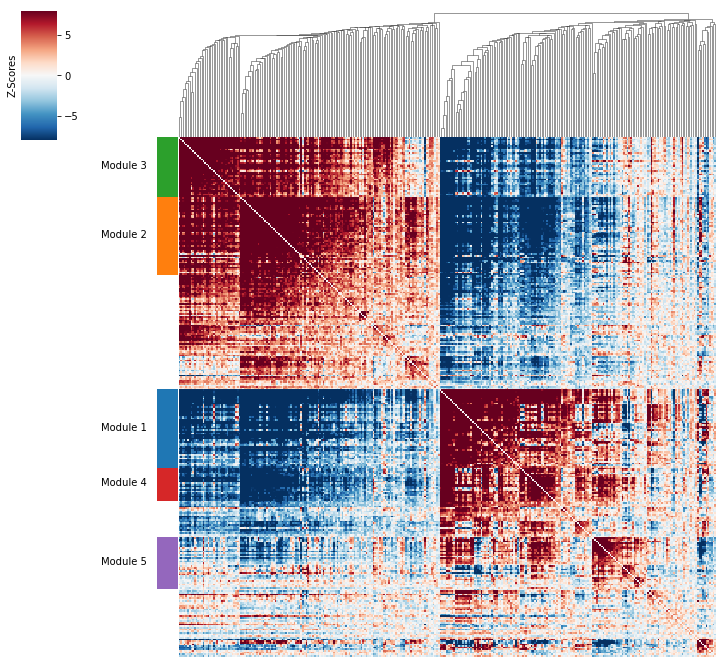

In [63]:
tum_res[1].plot_local_correlations()

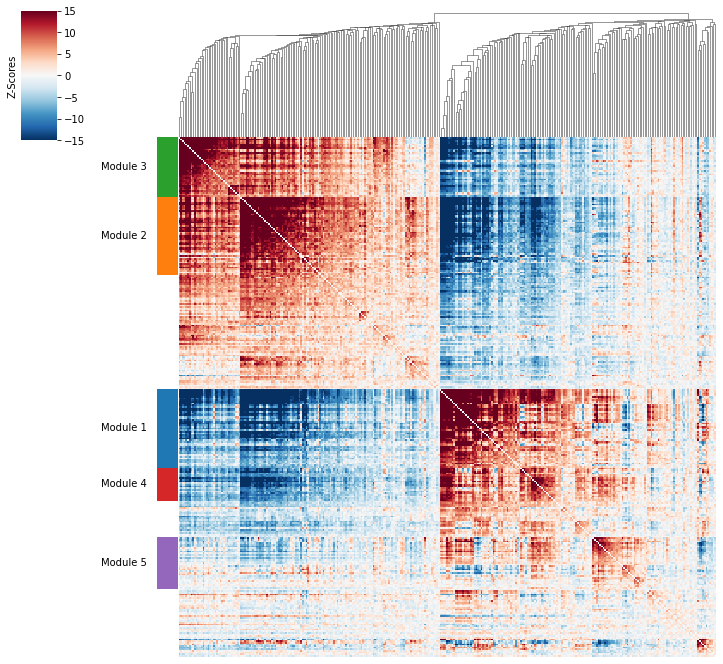

In [77]:
tum_res[1].plot_local_correlations(vmin=-15, vmax=15)
plt.savefig("visium_hotspot-BP-snrnaCellBender-4CTMarker.pdf")

In [65]:
module_scores = tum_res[1].calculate_module_scores()
tum_res[0].obs = tum_res[0].obs.iloc[:,:26]

Computing scores for 5 modules...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 13.55it/s]


In [73]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    tum_res[0].obs[key] = module_scores[c]
    module_cols.append(key)

In [91]:
for i, library in enumerate(
    ["Sample_RR3_A1_IGO_13263_5", "Sample_RR3_B1_IGO_13263_6"]
):
    ad = tum_res[0][tum_res[0].obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=module_cols,
        size=1.5,
        color_map = 'viridis',
        legend_loc=None,
        show=False,
        ncols=5,
        save="visium_hotspot-BP-snrnaCellBender-4CTMarker_spatial" +library+ ".pdf"
    )

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

/tmp/ipykernel_71622/2458283120.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


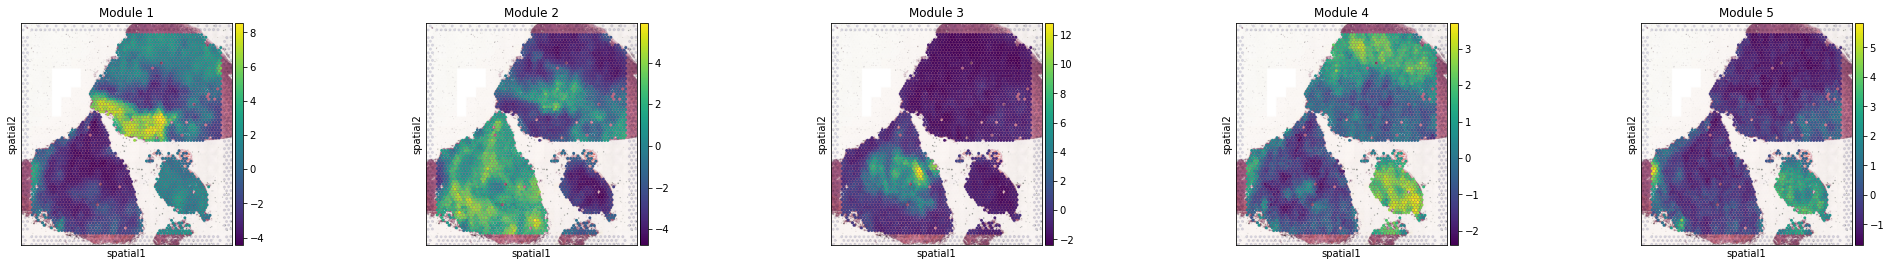

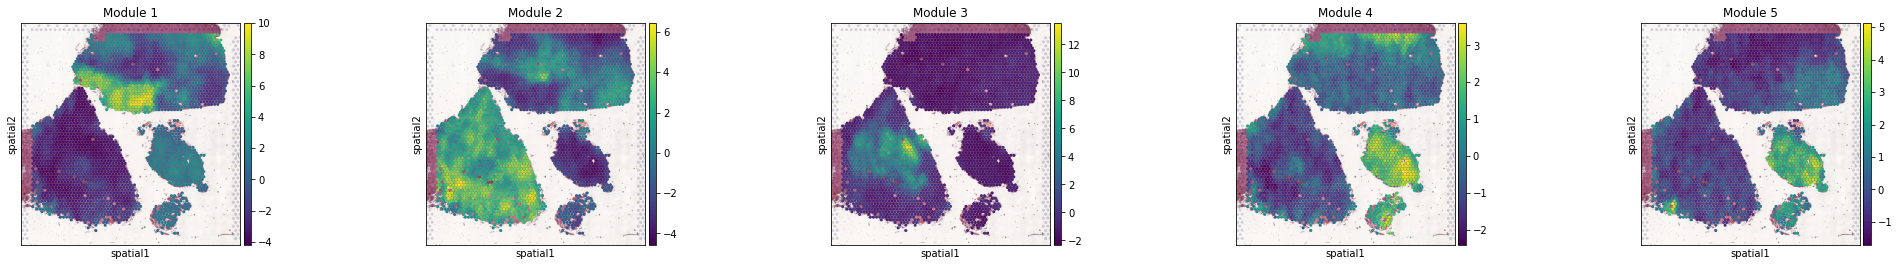

In [86]:
for i, library in enumerate(
    ["Sample_RR3_A1_IGO_13263_5", "Sample_RR3_B1_IGO_13263_6"]
):
    ad = tum_res[0][tum_res[0].obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=module_cols,
        size=1.5,
        color_map = 'viridis',
        legend_loc=None,
        show=False,
        ncols=5
    )

plt.tight_layout()

/tmp/ipykernel_71622/1276751132.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


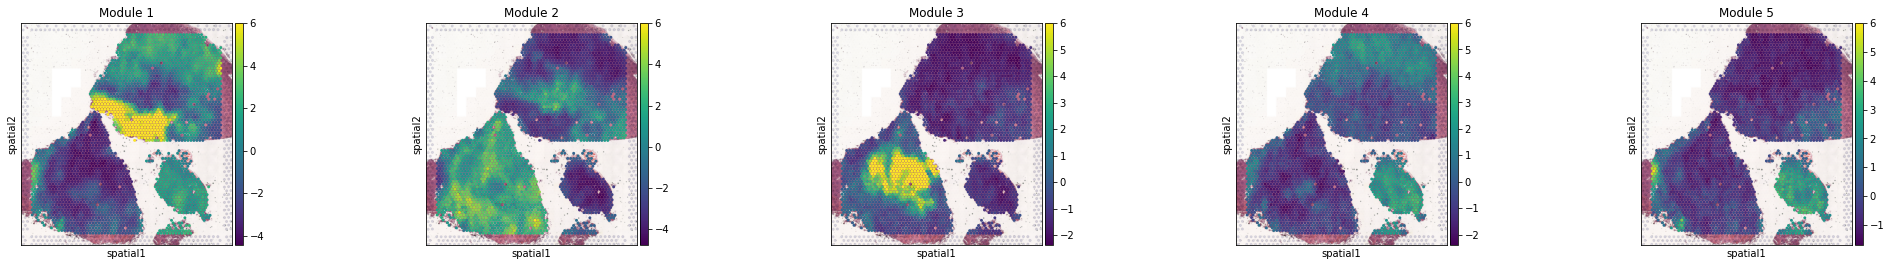

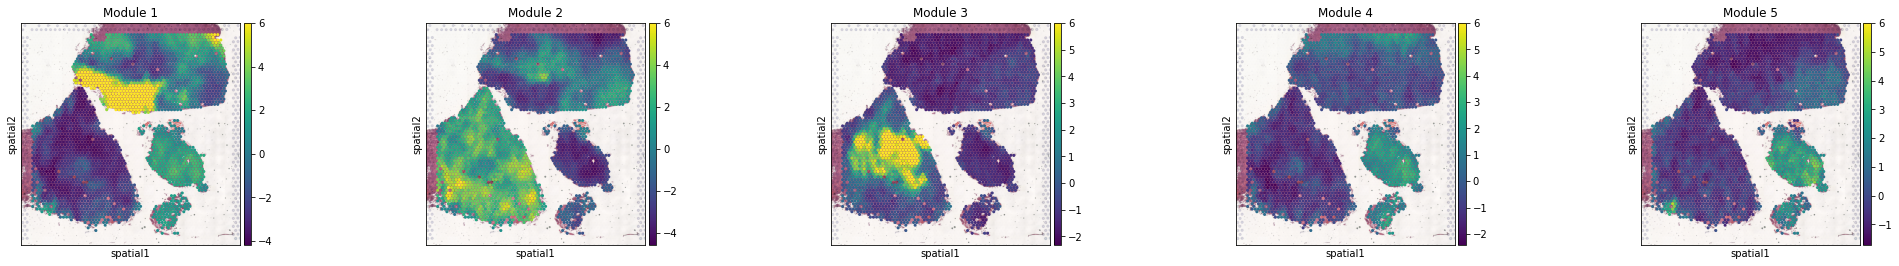

In [89]:
for i, library in enumerate(
    ["Sample_RR3_A1_IGO_13263_5", "Sample_RR3_B1_IGO_13263_6"]
):
    ad = tum_res[0][tum_res[0].obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=module_cols,
        size=1.5,
        color_map = 'viridis',
        legend_loc=None,
        show=False,
        ncols=5,
        vmax=6
    )

plt.tight_layout()

In [90]:
for i, library in enumerate(
    ["Sample_RR3_A1_IGO_13263_5", "Sample_RR3_B1_IGO_13263_6"]
):
    ad = tum_res[0][tum_res[0].obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=module_cols,
        size=1.5,
        color_map = 'viridis',
        legend_loc=None,
        show=False,
        ncols=5,
        vmax=6,
        save="visium_hotspot-BP-snrnaCellBender-4CTMarker_spatial" +library+ "_vmax6.pdf"
    )

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [68]:
for module_id in np.arange(1,(tum_res[1].modules.max()+1)):
    print(module_id)
    results = tum_res[1].results.join(tum_res[1].modules)
    results = results.loc[results.Module == module_id]
    print(results.sort_values('Z', ascending=False).head(20))

1
                C           Z           Pval            FDR  Module
Gene                                                               
Hes6     0.742675  119.981960   0.000000e+00   0.000000e+00     1.0
Ascl1    0.814395  113.494268   0.000000e+00   0.000000e+00     1.0
Prox1    0.651727   94.944332   0.000000e+00   0.000000e+00     1.0
Insm1    0.711389   94.826702   0.000000e+00   0.000000e+00     1.0
Hoxd8    0.595220   78.041721   0.000000e+00   0.000000e+00     1.0
Hoxd4    0.557920   74.695639   0.000000e+00   0.000000e+00     1.0
Sox1     0.601243   73.659316   0.000000e+00   0.000000e+00     1.0
Foxa2    0.549312   71.920471   0.000000e+00   0.000000e+00     1.0
Olig3    0.494224   69.058246   0.000000e+00   0.000000e+00     1.0
Tox      0.496276   65.981565   0.000000e+00   0.000000e+00     1.0
Pcbp4    0.520741   65.505642   0.000000e+00   0.000000e+00     1.0
Sox11    0.418395   55.728177   0.000000e+00   0.000000e+00     1.0
Six1     0.384514   54.638669   0.000000e+00  

In [69]:
results = tum_res[1].results.join(tum_res[1].modules)
results = results[results['Module'].notna() & (results['Module'] != -1)]

In [70]:
results.to_csv("Hotspot_visium_BP_snrnaCB_4CTMarker.csv")

In [71]:
tum_res[0].obs.to_csv("module_score_snrnaCB_4CTMarker.csv")

In [72]:
tum_res[2].to_csv('tum_hotspot_autoCorr_snrnaCB_4CTMarker.csv')

In [46]:
lcz = tum_res[1].compute_local_correlations(genes=tum_res[0].var.index, jobs=40)  

Computing pair-wise local correlation on 5038 features...


100%|█████████████████████████████| 12688203/12688203 [22:59<00:00, 9197.08it/s]


In [ ]:
lcz.to_csv('tum_hotspot_pairWiseCorr_snrnaCB_4CTMarker.csv')

In [ ]:
#compute un-deconovlved expression over the same set of genes 

In [47]:
tum_res[0]

AnnData object with n_obs × n_vars = 5966 × 5038
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'Barcode', 'library_id', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'tissue', 'tissue.type', 'week', 'nCount_BP.frac', 'nFeature_BP.frac', 'nCount_BP.Znk', 'nFeature_BP.Znk', 'NEPC_frac', 'tissue.1', 'row', 'col', 'imagerow', 'imagecol', 'nCount_NEPC.exp', 'nFeature_NEPC.exp', 'nCount_str.exp', 'nFeature_str.exp', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_adj', 'spatial_raw'
    layers: 'csc_counts'

In [48]:
adata_copy = st_adata.copy()
# Compute the total counts for each cell and store them in the .obs attribute
adata_copy.obs['total_counts'] = np.asarray(adata_copy.X.sum(1)).ravel()
    
# Convert the .X attribute to CSC format and store it in the .layers attribute
adata_copy.layers['csc_counts'] = adata_copy.X.tocsc()

#subest on exactly the same cell id and gene id
adata_copy = adata_copy[tum_res[0].obs_names,tum_res[0].var_names].copy()

In [49]:
adata_copy

AnnData object with n_obs × n_vars = 5966 × 5038
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'Barcode', 'library_id', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'tissue', 'tissue.type', 'week', 'nCount_BP.frac', 'nFeature_BP.frac', 'nCount_BP.Znk', 'nFeature_BP.Znk', 'NEPC_frac', 'tissue.1', 'row', 'col', 'imagerow', 'imagecol', 'nCount_NEPC.exp', 'nFeature_NEPC.exp', 'nCount_str.exp', 'nFeature_str.exp', 'row_adj', 'col_adj', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_adj', 'spatial_raw'
    layers: 'csc_counts'

In [50]:
# Create the Hotspot object and the neighborhood graph
hs_raw = hotspot.Hotspot(
    adata_copy,
    layer_key="csc_counts",
    model='danb',
    latent_obsm_key="spatial_adj",
    umi_counts_obs_key="total_counts",
)

np.random.seed(123)
hs_raw.create_knn_graph(
    weighted_graph=False, n_neighbors=6,
)
    
np.random.seed(123)
hs_results_raw = hs_raw.compute_autocorrelations(jobs=30)
hs_results_raw
     
np.random.seed(123)
lcz_raw = hs_raw.compute_local_correlations(tum_res[0].var.index, jobs=30)    
    
    

100%|█████████████████████████████████████| 5038/5038 [00:02<00:00, 1686.76it/s]


Computing pair-wise local correlation on 5038 features...


100%|█████████████████████████████| 12688203/12688203 [22:47<00:00, 9278.03it/s]


In [51]:
lcz_raw

Xkr4     Rgs20    Alkal1     Sntg1      Rrs1     Mybl1    Mcmdc2  \
Xkr4    0.000000 -1.113221 -0.702311 -0.534692 -8.704530 -2.055778 -0.681952   
Rgs20  -1.113221  0.000000 -0.698714 -0.196171  4.661187  1.050666  0.911139   
Alkal1 -0.702311 -0.698714  0.000000 -0.226954 -0.721930  0.514973 -0.446411   
Sntg1  -0.534692 -0.196171 -0.226954  0.000000  1.212553 -0.566331  0.083191   
Rrs1   -8.704530  4.661187 -0.721930  1.212553  0.000000  3.832277  1.442867   
...          ...       ...       ...       ...       ...       ...       ...   
Fancb  -0.956194  1.397967  1.045625 -0.841016  2.436877  0.183477  0.684194   
Gemin8 -0.456256  0.389410  1.156603  0.243731 -0.124301  1.677623  0.552276   
Gpm6b   6.272042 -1.691086 -0.712486 -0.879616 -2.234449 -0.250723 -1.140548   
Tceanc  3.570171  0.898872 -0.266370  0.005523 -7.342925 -0.637384 -0.043882   
Prps2   3.860172 -0.954381 -0.120388  1.370576 -4.186366  1.662010 -1.755458   

           Cops5     Prex2  A830018L16Rik  ...     Ppef1     Reps2     Rbbp7  \
Xkr4   -1.249649  3.489200      -0.853877  ...  1.520077 -3.095025  0.578416   
Rgs20   3.536213 -0.320391       1.269906  ...  1.345873  1.335007 -0.092518   
Alkal1 -0.119985 -0.040121      -0.291118  ... -0.208781 -0.332823 -0.948620   
Sntg1  -0.049547  2.025054       4.323603  ... -0.279121  1.520324  1.266602   
Rrs1    3.474185 -2.781265       0.868338  ...  0.190819 -0.221836 -1.011131   
...          ...       ...            ...  ...       ...       ...       ...   
Fancb  -0.028724  0.096546      -1.526448  ... -0.745426  0.234358  0.703911   
Gemin8  0.298013  1.186330       0.095914  ... -0.674394 -0.235919 -1.895376   
Gpm6b  -1.588443  1.709857      -0.617556  ...  1.136128 -1.599472  0.315281   
Tceanc -1.339045  0.796882      -0.609508  ... -1.182641  0.395835 -0.922897   
Prps2  -1.046282  0.432382      -0.294959  ... -1.451473 -2.082339 -0.636600   

          Siah1b      Piga     Fancb    Gemin8     Gpm6b    Tceanc     Prps2  
Xkr4   -1.095058 -0.588935 -0.956194 -0.456256  6.272042  3.570171  3.860172  
Rgs20   0.070296  2.263964  1.397967  0.389410 -1.691086  0.898872 -0.954381  
Alkal1  0.141052  1.318412  1.045625  1.156603 -0.712486 -0.266370 -0.120388  
Sntg1  -0.539456  0.522298 -0.841016  0.243731 -0.879616  0.005523  1.370576  
Rrs1    3.610707  0.902889  2.436877 -0.124301 -2.234449 -7.342925 -4.186366  
...          ...       ...       ...       ...       ...       ...       ...  
Fancb   0.855976  0.372151  0.000000  0.556850 -1.480462 -1.763493  0.232798  
Gemin8  0.469850  1.014621  0.556850  0.000000  1.016465 -1.164017  1.932199  
Gpm6b   0.188145 -0.804204 -1.480462  1.016465  0.000000  2.087022  2.319564  
Tceanc -2.986473  1.379604 -1.763493 -1.164017  2.087022  0.000000  2.603197  
Prps2   1.708121 -1.403172  0.232798  1.932199  2.319564  2.603197  0.000000  

[5038 rows x 5038 columns]

In [56]:
modules = tum_res[1].create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

-1     2730
 3      172
 6      147
 1      128
 4      117
 25     105
 18     101
 7       92
 14      70
 40      68
 11      67
 38      61
 32      60
 10      57
 23      55
 34      48
 29      45
 44      44
 2       43
 22      42
 26      41
 21      40
 8       37
 16      36
 12      35
 13      33
 46      32
 19      30
 41      29
 28      28
 45      28
 17      27
 5       25
 9       24
 15      24
 48      24
 43      23
 20      23
 42      22
 36      20
 37      20
 27      19
 39      18
 24      18
 51      17
 31      17
 47      17
 50      16
 33      16
 35      16
 49      16
 30      15
Name: Module, dtype: int64

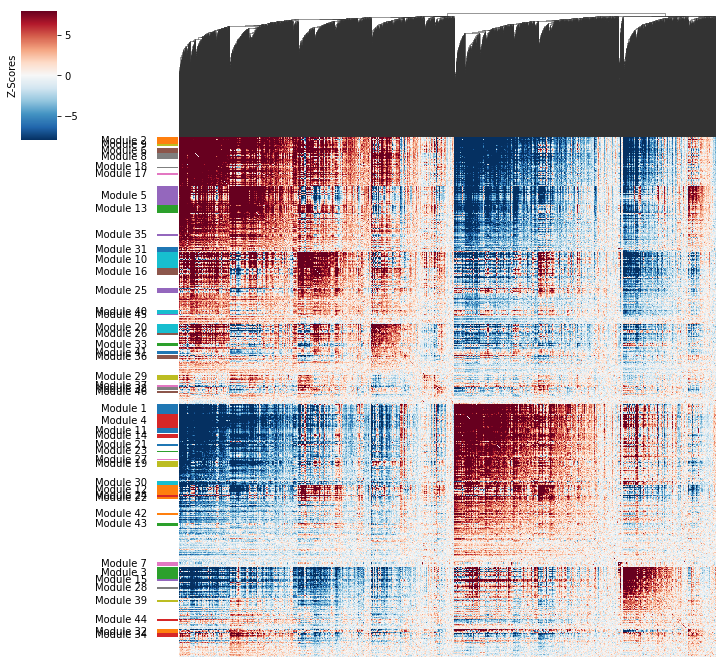

In [53]:
hs_raw.plot_local_correlations()

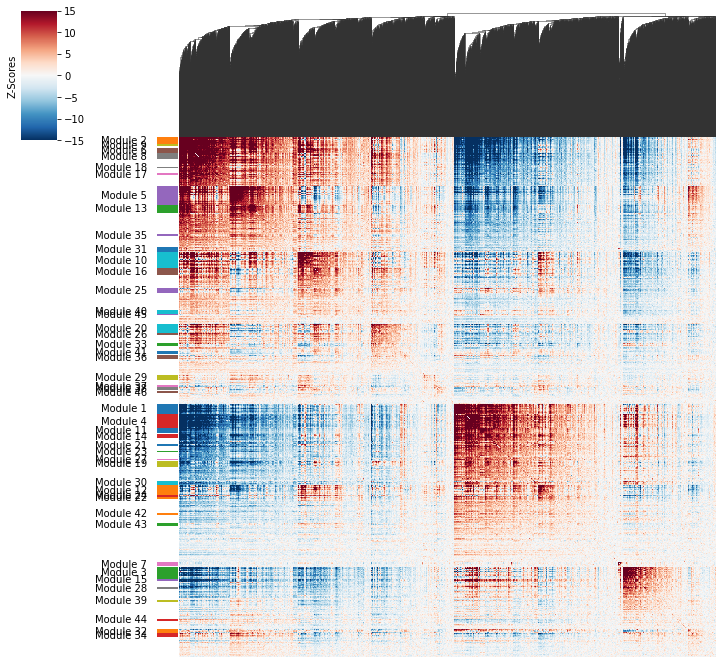

In [54]:
hs_raw.plot_local_correlations(vmin=-15, vmax=15)

In [ ]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata_copy.obs[key] = module_scores[c]
    module_cols.append(key)

In [ ]:
for i, library in enumerate(
    ["Sample_RR3_A1_IGO_13263_5", "Sample_RR3_B1_IGO_13263_6"]
):
    ad = adata_copy[adata_copy.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=module_cols,
        size=1.5,
        color_map = 'viridis_r',
        legend_loc=None,
        show=False
    )

plt.tight_layout()

In [ ]:
hs_results_raw.to_csv('all_hotspot_autoCorr_snrnaCB_4CTMarker.csv')

In [ ]:
lcz_raw.to_csv('all_hotspot_pairWiseCorr_snrnaCB_4CTMarker.csv')